In [633]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.core.pylabtools import figsize

#first we simulate some data to show that a split point can be found 
NUM_DRAWS = 10000
NUM_SAMPLES = 500
TRUE_PROPS_1 = [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10]
TRUE_PROPS_2 = [0.10, 0.45, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.10]

TRUE_TAU = 250

def generate_data():
    data = np.zeros((NUM_SAMPLES,len(TRUE_PROPS_1)))
    for i in range(NUM_SAMPLES):
        if(i < TRUE_TAU):
            x = np.random.multinomial(NUM_DRAWS, TRUE_PROPS_1)
            data[i]=x
        else:
            x = np.random.multinomial(NUM_DRAWS, TRUE_PROPS_2)
            data[i]=x
    return data

In [635]:
sim_data = generate_data()

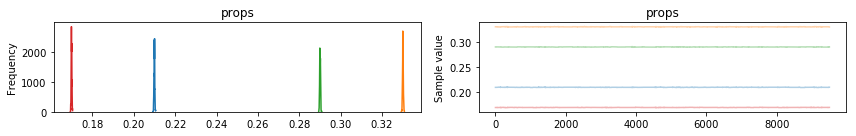

In [555]:
pm.traceplot(trace1[500:])
plt.show()

In [556]:

# Three Dirichlets
with pm.Model():
    alphas2 = np.ones((num_dirichlets, num_alphas_per_dirichlet))
    p = pm.Dirichlet('p', alphas2, shape=(3,4))

In [667]:
import theano.tensor as t

@theano.compile.ops.as_op(itypes=[t.lscalar, t.dvector, t.dvector],otypes=[t.dmatrix])
def dir_(tau=tau, props_1=props_1,props_2=props_2):
        
        out = np.zeros((len(sim_data[:]),len(sim_data[0])))
        #for i in range(len(out)):
        #    if(tau>i):
        #        out[i] = props_1
        #    else:
        #        out[i] = props_2
        out[:tau] = props_1
        out[tau:] = props_2
        return np.asmatrix(out)
       

In [648]:
from pymc3.math import switch

num_alphas_per_dirichlet = 10
splitPoint = np.arange(len(sim_data[:]))

# One Dirichlet
with pm.Model():
    alphas_1 = np.ones(num_alphas_per_dirichlet)
    
    props_1 = pm.Dirichlet('props1', alphas_1)
    props_2 = pm.Dirichlet('props2', alphas_1)   
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(sim_data[:]))
    
    y_hat = pm.Deterministic('y_hat',dir_(tau,props_1,props_2))
    
    #switchPoint = pm.DiscreteUniform("tau", lower=0, upper=len(sim_data[:]))
    
    #change_ = pm.math.switch(switchPoint >= splitPoint, props_1, props_2)
    
    #observed = pm.Multinomial('draws', p=change_, n=NUM_DRAWS, observed=sim_data)
        
    observed = pm.Multinomial('draws', p=y_hat, n=NUM_DRAWS, observed=sim_data)
    
    trace = pm.sample(10000, tune=500, step=pm.Metropolis())
    
    

/Users/matbutle/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
100%|██████████| 10500/10500 [00:17<00:00, 605.67it/s]


In [649]:
tau_samples = trace['tau']
props_1_samples = trace['props1']
props_2_samples = trace['props2']

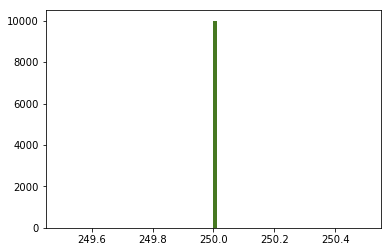

In [650]:
plt.hist(tau_samples, bins=100, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", rwidth=2.)
#plt.xticks(np.arange(len(sim_data)))

#plt.legend(loc="upper left")
#plt.ylim([0, .75])
#plt.xlim([35, len(sim_data)-20])
#plt.xlabel(r"$\tau$ (in days)")
#plt.ylabel("probability");
plt.show()

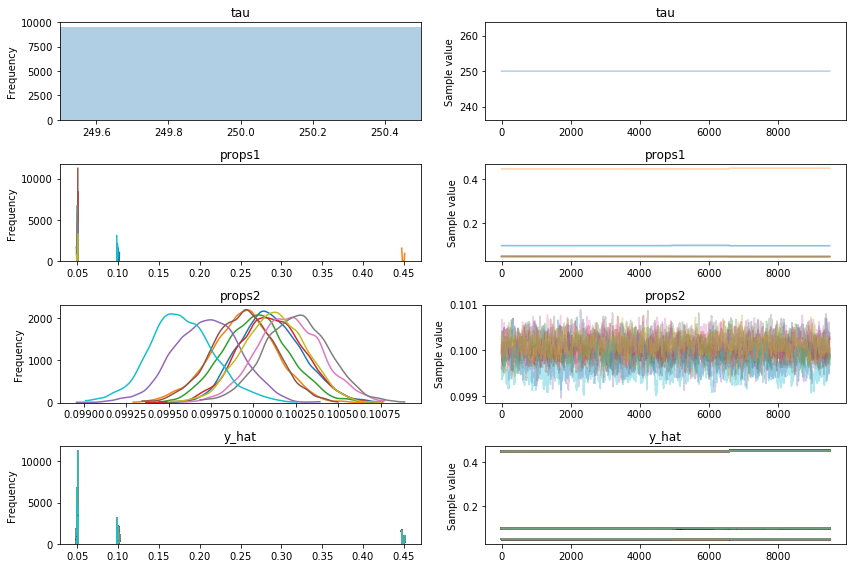

In [651]:
pm.traceplot(trace[500:])
plt.show()

In [652]:
def summarize(mcmc, field):
    results = mcmc[field]
    results = zip(*results)
    means = []
    stds = []
    for r in results:
        m = np.mean(r)
        v = np.std(r)
        means.append(m)
        stds.append(v)
    #means.append(1.0 - sum(means))
    print
    print("---")
    print(means)
    print(stds)

In [653]:
summarize(trace, "props1")

---
[0.10019575258779419, 0.44838988277431674, 0.049739316258445729, 0.050903086792135149, 0.050522607143011718, 0.050537047290451775, 0.049969245131069727, 0.050185256510832187, 0.050599687841025934, 0.098958117670916862]
[0.00091749623514345013, 0.0017042235932237231, 0.00049754550867174042, 0.00043045726585376519, 0.00065002560492845448, 0.00031897804827508622, 0.00053713836762247201, 0.00028892634159273549, 0.00070659529985744212, 0.00068357659333828581]


In [654]:
summarize(trace, "props2")

---
[0.10010236485005096, 0.099938398694764174, 0.1000201857466696, 0.10010785804834513, 0.099725250213576727, 0.099937891678327839, 0.10021052908308746, 0.10025795486181806, 0.10012459059625484, 0.099574976227105191]
[0.00018476435214680618, 0.00019200931114638905, 0.00019192322594158842, 0.00018921766723313738, 0.000193195497671444, 0.00018275351395718114, 0.00019233280516485978, 0.00018977552145139348, 0.00018317428193533221, 0.00019182235425624507]


In [655]:
np.mean(trace['tau'])

250.0

In [656]:
np.std(trace['tau'])

0.0

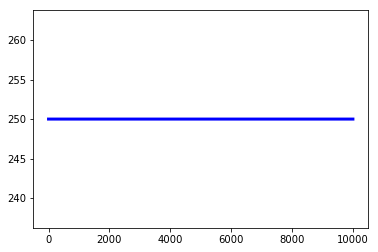

In [661]:
plt.plot(tau_samples,label="trace of tau",c="blue",lw=3)
plt.show()

In [663]:
np.shape(props_1_samples[:,1])

(10000,)

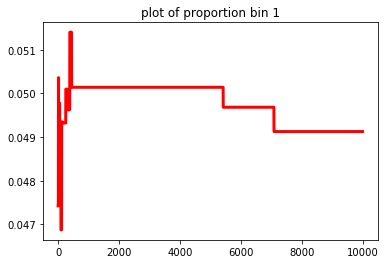

In [666]:
plt.plot(props_1_samples[:,2],c="red",lw=3)
plt.title("plot of proportion bin 1")
plt.show()

In [ ]:
for i in range(500):
    print i